In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math

In [45]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]

In [89]:
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False
        pe.shape

torch.Size([5000, 512])

In [90]:
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

In [91]:
position.shape

torch.Size([5000, 1])

In [92]:
div_term.shape

torch.Size([256])

In [93]:
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

In [75]:
import matplotlib.pyplot as plt

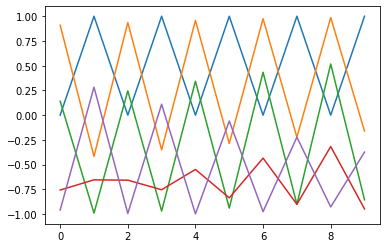

In [81]:
plt.plot(pe[0][:10])
plt.plot(pe[2][:10])
plt.plot(pe[3][:10])
plt.plot(pe[4][:10])
plt.plot(pe[5][:10])

In [99]:
pe.shape

torch.Size([5000, 512])

In [107]:
pe.T.shape

torch.Size([512, 5000])

In [102]:
pe[:10][0].shape

torch.Size([512])

In [106]:
pe[:10][0][:10]

tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1.])

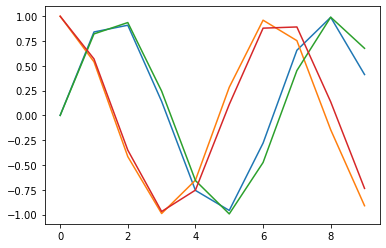

In [112]:
plt.plot(pe.T[0, :10])
plt.plot(pe.T[1, :10])
plt.plot(pe.T[2, :10])
plt.plot(pe.T[3, :10])


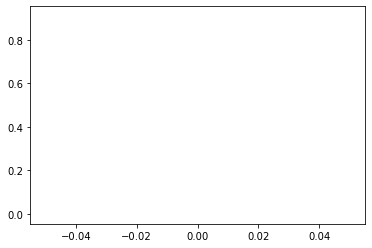

In [103]:
plt.plot(pe[:10][0])
plt.plot(pe[:10][1])
plt.plot(pe[:10][2])
plt.plot(pe[:10][3])

In [82]:
pe.shape

torch.Size([5000, 512])

In [83]:
pe = pe.unsqueeze(0)

In [84]:
pe.shape

torch.Size([1, 5000, 512])

In [86]:
pe[:, :10].shape

torch.Size([1, 10, 512])

In [62]:
        pe = pe.unsqueeze(0)

In [63]:
pe

tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  8.2186e-01,  ...,  1.0000e+00,
           1.0366e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.3641e-01,  ...,  1.0000e+00,
           2.0733e-04,  1.0000e+00],
         ...,
         [ 9.5625e-01, -2.9254e-01,  9.3594e-01,  ...,  8.5926e-01,
           4.9515e-01,  8.6881e-01],
         [ 2.7050e-01, -9.6272e-01,  8.2251e-01,  ...,  8.5920e-01,
           4.9524e-01,  8.6876e-01],
         [-6.6395e-01, -7.4778e-01,  1.4615e-03,  ...,  8.5915e-01,
           4.9533e-01,  8.6871e-01]]])

In [64]:
pe.shape

torch.Size([1, 5000, 512])

In [46]:
pe = PositionalEmbedding(512)

In [47]:
inpt = torch.Tensor(321,96,5)

In [48]:
inpt.shape

torch.Size([321, 96, 5])

In [49]:
embedded_inpt = pe(inpt)

In [50]:
embedded_inpt.shape

torch.Size([1, 96, 512])

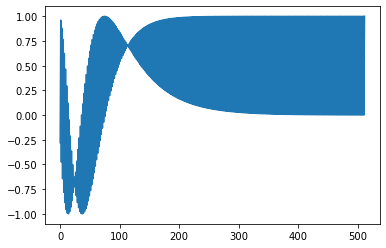

In [125]:
plt.plot(embedded_inpt[0][6])

In [51]:
class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model, 
                                    kernel_size=3, padding=padding, padding_mode='circular')
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight,mode='fan_in',nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1,2)
        return x

In [52]:
inpt.permute(0, 2, 1).shape

torch.Size([321, 5, 96])

In [54]:
token_embedding = TokenEmbedding(5, 512)

In [55]:
token_inpt = token_embedding(inpt)

In [56]:
token_inpt.shape

torch.Size([321, 96, 512])

In [57]:
class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4; hour_size = 24
        weekday_size = 7; day_size = 32; month_size = 13

        Embed = nn.Embedding
        if freq=='t':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)
    
    def forward(self, x):
        x = x.long()
        
        minute_x = self.minute_embed(x[:,:,4]) if hasattr(self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:,:,3])
        weekday_x = self.weekday_embed(x[:,:,2])
        day_x = self.day_embed(x[:,:,1])
        month_x = self.month_embed(x[:,:,0])
        
        return hour_x + weekday_x + day_x + month_x + minute_x

In [59]:
(embedded_inpt + token_inpt).shape

torch.Size([321, 96, 512])